<h1 align='center'> Medical Insurance Premium Prediction <h1>

Asuransi adalah sebuah perjanjian antara dua orang atau lebih di mana pihak tetanggung membayarkan iuran/kontribusi/premi untuk mendapat perggantian atas risiko kerugian, kerusakan, atau kehilangan, yang terjadi akibat peristiwa yang tidak terduga. Salah satu jenis asuransi yaitu asuransi kesehatan, yang mana asuransi kesehatan memberikan perlindungan dengan jaminan biaya kesehatan dan jatuh sakit.

Perusahaan asuransi kesehatan dapat menghasilkan uang juka lebih banyak mengumpulkan uang dari pada yang dihabiskan untuk perawatan medis penerima. Terdapat beberapa metode untuk menghitung uang pertanggungan yaitu:
- Metode human life value
- Metode income based value
- Metode financial needs based value

Di sisi lain, meskipun beberapa kondisi lebih umum untuk segmen populasi tertentu, biaya pengobatan sulit diprediksi karena sebagian besar uang berasal dari kondisi langka pasien.

Tujuan dari project ini adalah untuk memprediksi biaya asuransi berdasarkan kondisi tertentu seperti usia, indeks massa tubuh, merokok atau tidak dan lain sebagainya. Data ini didapatkan dari kaggle insurance.csv, dengan menggunakan data tersebut harapannya project ini dapat membantu pihak perusahaan dalam menentukan harga premi tahunan lebih tinggi atau lebih rendah sesuai dengan biaya perawatan yang diharapkan

Content Overview:
1. Reading and understanding data
2. Exploratory data
3. Data pre-processing
4. Build predictive model
5. Final model
6. Single prediction of observation
7. Conclution

## 1. Reading and understanding data

### Import library

In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import joblib
import random
import scipy.stats as stats

from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRFRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_squared_error,r2_score,mean_squared_error, make_scorer

### Load dataset

In [3]:
dataset = pd.read_csv('insurance.csv')
dataset2 = dataset.copy()
dataset.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


informasi singkat dataset:
- age: usia penerima asuransi
- jenis kelamin: jenis kelamin penerima asuransi (perempuan, laki-laki)
- bmi: body mass index, atau metrik standar yang digunakan untuk menentukan berat badan sehat atau tidak (kg/m**2)
- children: jumlah anak yang ditanggung oleh asuransi kesehatan.
- smoker: penerima pasien merokok atau tidak
- wilayah: daerah perumahan penerima asuransi di US (northeast, southeast, southwest, northwest)

### Checking missing values

In [4]:
dataset.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

dataset tersebut tidak mempunyai null value

### Data overview

In [5]:
dataset.shape

(1338, 7)

In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [7]:
dataset = dataset.astype({'children':object})

In [8]:
dataset.describe() 

,age,bmi,charges
count,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,13270.422265
std,14.049960,6.098187,12110.011237
min,18.000000,15.960000,1121.873900
25%,27.000000,26.296250,4740.287150
50%,39.000000,30.400000,9382.033000
75%,51.000000,34.693750,16639.912515
max,64.000000,53.130000,63770.428010


In [9]:
cat_var = dataset.select_dtypes(include='object')
cat_var.describe()

,sex,children,smoker,region
count,1338,1338,1338,1338
unique,2,6,2,4
top,male,0,no,southeast
freq,676,574,1064,364


In [129]:
for i,c in enumerate(cat_var):
    print(c,'=',dataset[c].unique())

sex = ['female' 'male']
children = [0 1 3 2 5 4]
smoker = ['yes' 'no']
region = ['southwest' 'southeast' 'northwest' 'northeast']


informasi singkat mengenai data:
- jumlah data sebanyak 1338, dengan 6 features dan 1 variabel target
- dataset tersebut terdiri dari categorical ('object') dan numerical ('int' dan 'float') data
- charges, rata - rata biaya sebesar 13270,42 dengan biaya terkecil dan terbesarnya adalah 1121.87 dan 63770.42
- age, rata - rata umur penerima asuransi adalah 39
- bmi, massa index terbesar yaitu 53.13 dan yang terkecil yaitu 15.96
- sex, jumlah jenis kelamin penerima asuransi terbanyak adalah laki laki yaitu 676 orang
- children, frekuensi jumlah anak yang ditanggung asuransi paling banyak yaitu 0 dengan frekuensi 574 orang
- smoker, mayoritas penerima asuransi tidak merokok
- region, terdapat 4 jenis wilayah penerima asuransi

## 2. Exploratory data

### a. Univariate analysis

#### Variable target

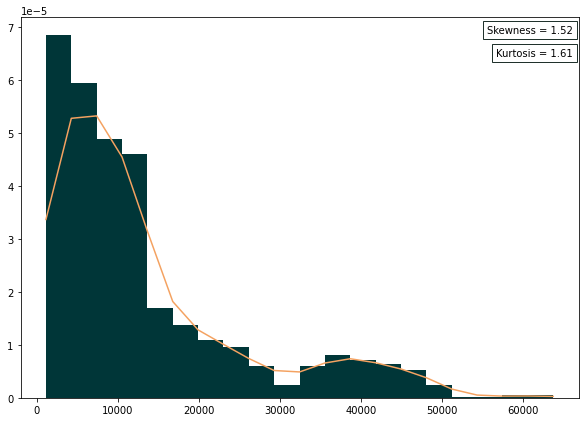

In [11]:
fig,ax = plt.subplots(figsize=(10,7))
density = stats.gaussian_kde(dataset['charges'])
n,x,_ = ax.hist(dataset['charges'],bins=20,density=True,color='#003638')
ax.text(0.99,0.98,'Skewness = '+str(round(dataset['charges'].skew(),2)),color='black', ha='right', va='top',transform=ax.transAxes,
                     bbox={'facecolor': 'None', 'alpha': 0.9, 'pad': 4, 'edgecolor':'#081c15'})
ax.text(0.99,0.92,'Kurtosis = '+str(round(dataset['charges'].kurt(),2)),color='black', ha='right', va='top',transform=ax.transAxes,
                     bbox={'facecolor': 'None', 'alpha': 0.9, 'pad': 4, 'edgecolor':'#081c15'})
ax.plot(x,density(x),c='#f4a261')
plt.show()

Hasil dari plotting histogram diatas menunjukan bahwa pada variabel target yaitu charges memiliki skewness sebesar 1.52 yang mana jumlah rata - rata biaya lebih besar dari median, atau biaya yang ditanggung penerima asuransi kebanyakan masih dibawah rata- rata, hanya sedikit orang dengan biaya asuransi kesehatan yang mahal.

#### Numerical variable

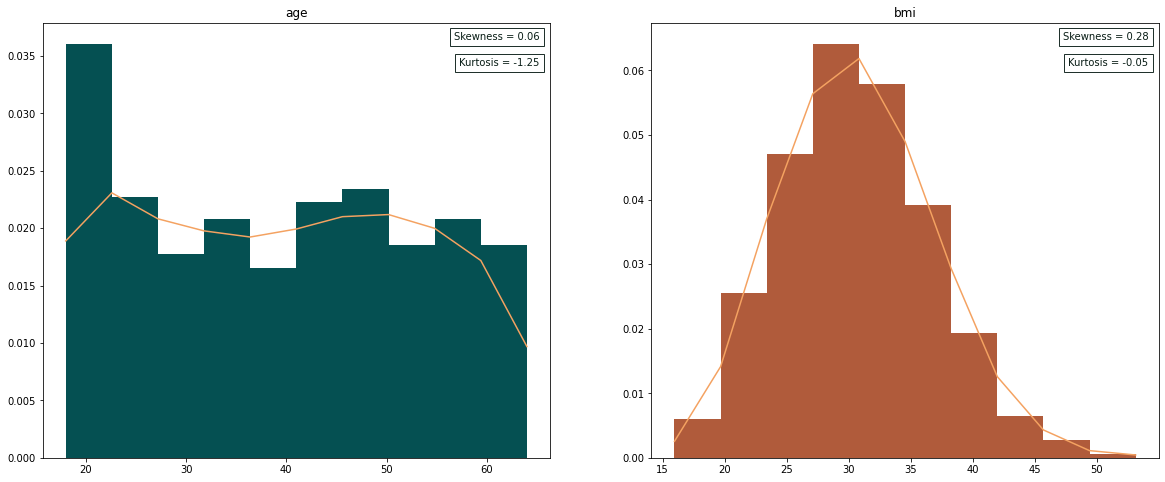

In [12]:
num_var = dataset.select_dtypes(include=['int64','float64'])
color = ['#055052','#B05B3B','#B97A95']
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(20,8))
for i in range(0,len(num_var.columns)-1):
    n,x,_ = ax[i].hist(num_var.iloc[:,i],density=True,color=color[i])
    ax[i].set_title(num_var.columns[i])
    ax[i].text(0.98,0.98,'Skewness = '+str(round(num_var.iloc[:,i].skew(),2)),color='#081c15', ha='right', va='top',transform=ax[i].transAxes,
                     bbox={'facecolor': 'None', 'alpha': 0.9, 'pad': 4, 'edgecolor':'#081c15'})
    ax[i].text(0.98,0.92,'Kurtosis = '+str(round(num_var.iloc[:,i].kurt(),2)),color='#081c15', ha='right', va='top',transform=ax[i].transAxes,
                     bbox={'facecolor': 'None', 'alpha': 0.9, 'pad': 4, 'edgecolor':'#081c15'})
    
    density =  stats.gaussian_kde(num_var.iloc[:,i])
    ax[i].plot(x,density(x),c='#f4a261')
plt.show()

- age: distribusi umur hampir tidak memiliki kemencengan, atau rata - rata dan nilai tengah umur hampir sama , namun memiliki- nilai kurtosis dibawah 3.
- bmi : distribusi bmi memiliki nilai kemencengan dibawah 1 yang mana nilai tersebut masih relativ kecil, sehingga rata - rata dan median bmi hampir memiliki nilai yang sama, namun nilai kurtosis masih dibawah 3

#### Categorical variable

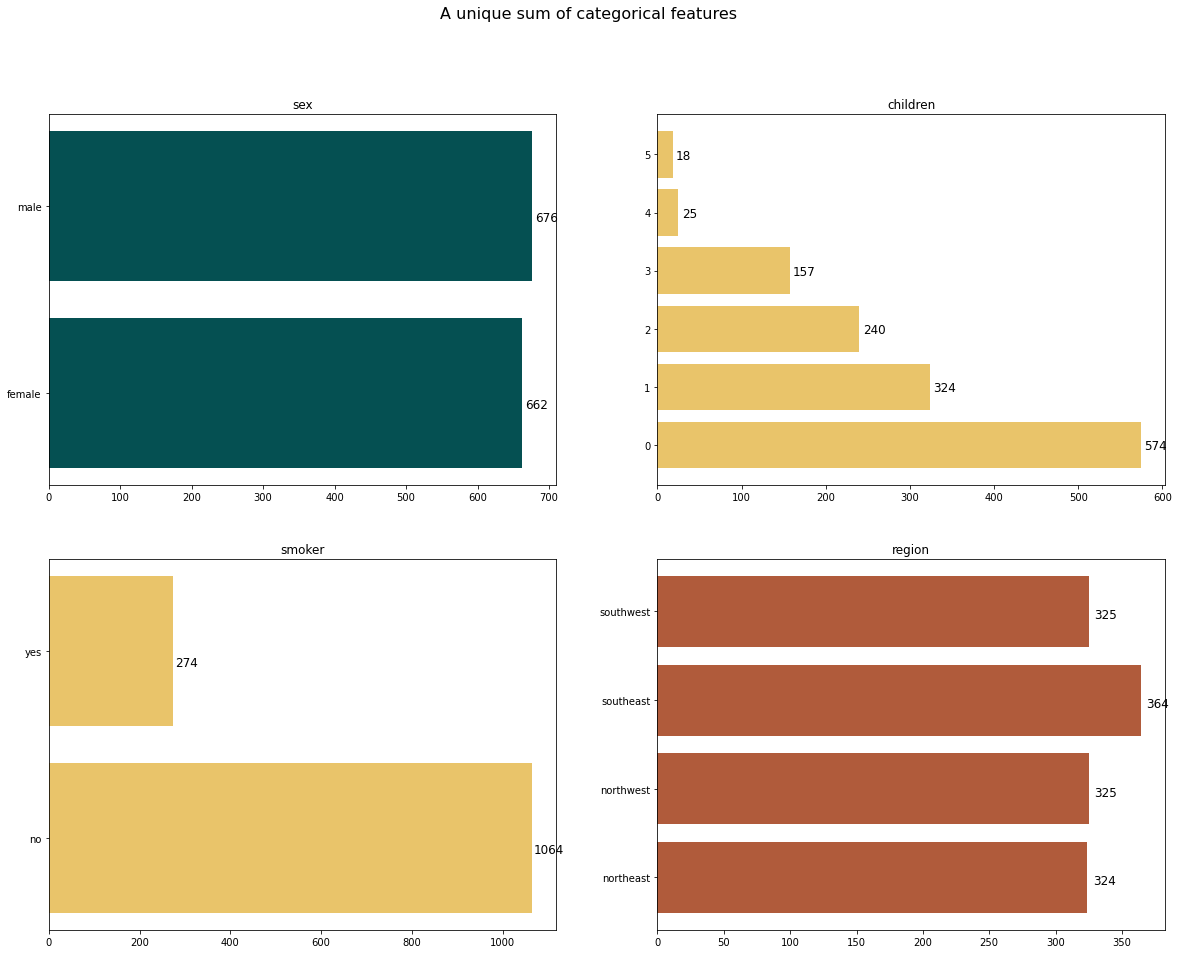

In [13]:
cat_var = dataset.select_dtypes(include='object')
i=0
color = ['#055052','#e9c46a','#B05B3B']
def addlabels(x,y,r,c):
    for i in range(len(x)):
        ax[r][c].text(y[i]+4,i-0.08,y[i],fontdict={'color':  'black',
                                                    'weight': 'normal',
                                                    'size': 12,})

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(20,15))
fig.suptitle("A unique sum of categorical features", fontsize=16)
for r in range(0,2):
    for c in range(0,2):
        cat = cat_var.groupby(cat_var.columns[i]).size().reset_index(name='count')
        ax[r][c].barh(cat.iloc[:,0].unique(),cat.iloc[:,1].values,color=color[c+r])
        addlabels(cat.iloc[:,0].unique(),cat.iloc[:,1].values,r,c)
        
        ax[r][c].set_title(cat_var.columns[i])
        i+=1
plt.show()

- sex: setiap gender pada fitur sex memiliki jumlah yang hampir sama, atau tidak miliki perbedaan nilai secara signifikan
- children: frekuensi children memiliki perbedaan yang cukup tinggi, di mana 0 anak memiliki frekuensi sebesar 576 sedangkan 5 anak memiliki frekuensi sebesar 18, hal ini menunjukan perbedaan jumlah anak yang signifikan
- smoker: mayoritas penerima asuransi tidak merokok, dengan jumlah antara perokok dengan bukan perokok memiliki perbedaan yang tinggi
- region : penerima asuransi pada setiap wilayah relatif sama

### b. Bivariate analysis

#### Scater plot numerical variable vs target

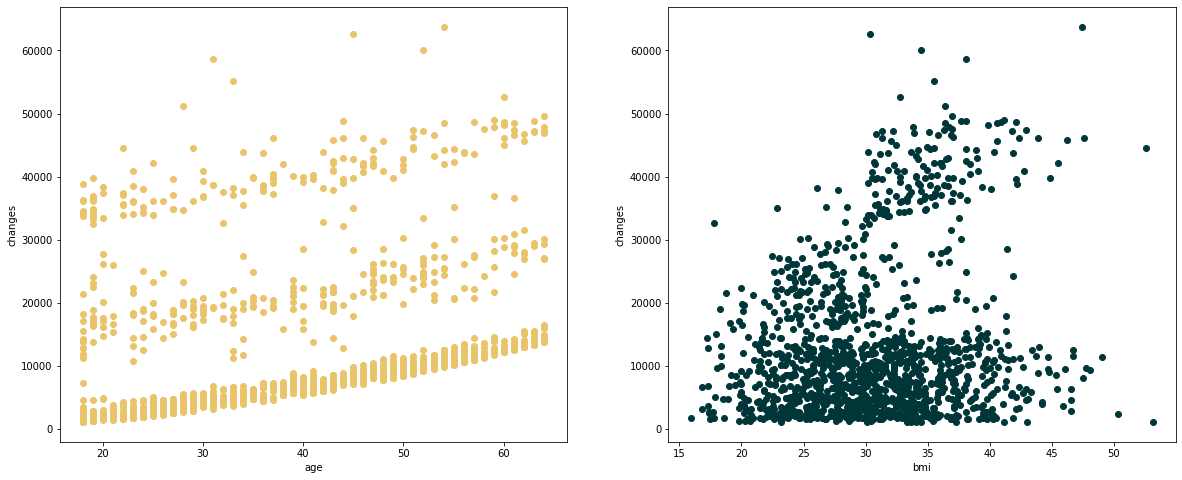

In [14]:
num_var = dataset.select_dtypes(include=['int64','float64'])
color = ['#e9c46a','#003638']

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
for r in range(0,2):
    ax[r].scatter(num_var.iloc[:,r],dataset.charges,color=color[r])
    ax[r].set_xlabel(num_var.columns[r])
    ax[r].set_ylabel("changes")
plt.show()

- sebaran data umur dengan biaya tidak menunjukan pengaruh yang begitu besar, tetapi sebagian kecil orang dengan umur yang lebih tua akan mendapatkan biaya yang tinggi.
- sebaran data bmi dengan biaya juga tidak menunjukan pengaruh yang begitu besar, tetapi beberapa orang dengan bmi lebih dari 30 kemungkinan mendapat biaya asuransi yang tinggi

#### Bar chart categorical variable vs target

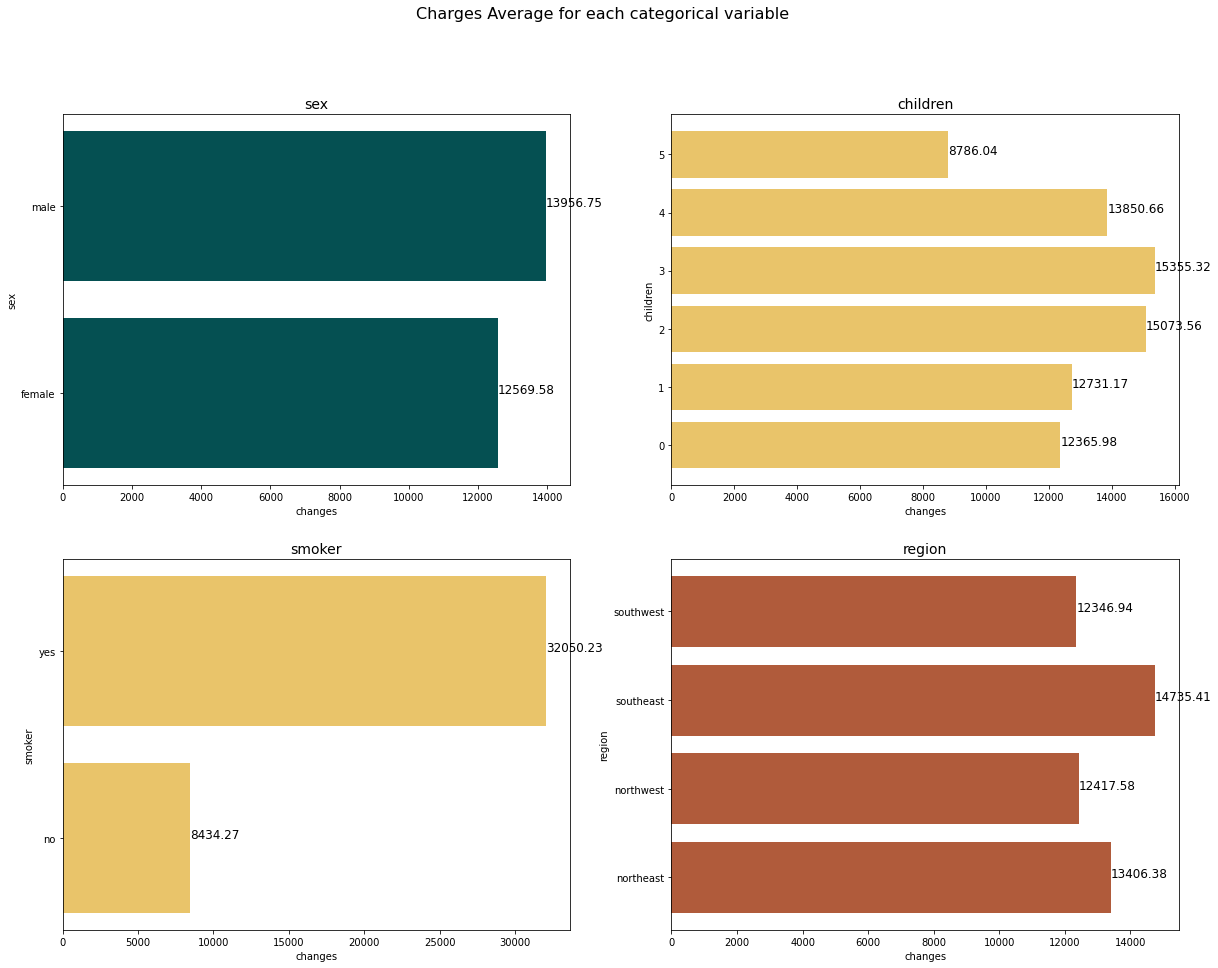

In [15]:
cat_var = dataset.select_dtypes(include='object')
i=0
color = ['#055052','#e9c46a','#B05B3B']
def addlabels(x,y,r,c):
    for i in range(len(x)):
        ax[r][c].text(y[i],i,round(y[i],2),fontdict={'color':  'black',
                                                    'weight': 'normal',
                                                    'size': 12,})
        
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,15))
fig.suptitle("Charges Average for each categorical variable", fontsize=16)
for r in range(0,2):
    for c in range(0,2):
        cat_tar = dataset.groupby(cat_var.columns[i]).mean()['charges']
        ax[r][c].barh(cat_tar.index,cat_tar.values,color=color[c+r])
        addlabels(cat_tar.index,cat_tar.values,r,c)
        ax[r][c].set_title(cat_var.columns[i],fontsize=14)
        ax[r][c].set_ylabel(cat_var.columns[i])
        ax[r][c].set_xlabel("changes")
        i+=1
plt.show()

- biaya pada setiap gender hampir memiliki jumlah rata rata yang sama, atau perbedaan gender tidak terlalu berpengaruh terhadap biaya asuransi
- perbedaan jumlah anak juga tidak terlalu berpengaruh terhadap biaya asuransi, di mana semakin banyak anak tidak selalu mahal biaya asuransinya, begitu juga sebaliknya
- orang yang merokok pasti memiliki biaya asuransi yang tinggi dan orang yang tidak merokok memiliki pasti memiliki biaya asuransi yang rendah
- perbedaan wilayah tidak terlalu berpengaruh terhadap biaya asuransi yang harus dibayar

### c. Multivariate analysts

Dari analisis antara fitur dengan tergetnya, kita dapat mengambil kesimpulan bahwa fitur dengan pengaruh yang paling tinggi adalah smoker. untuk itu kita akan mencoba melihat hubungan antara variabel smoker dangan variabel lainya

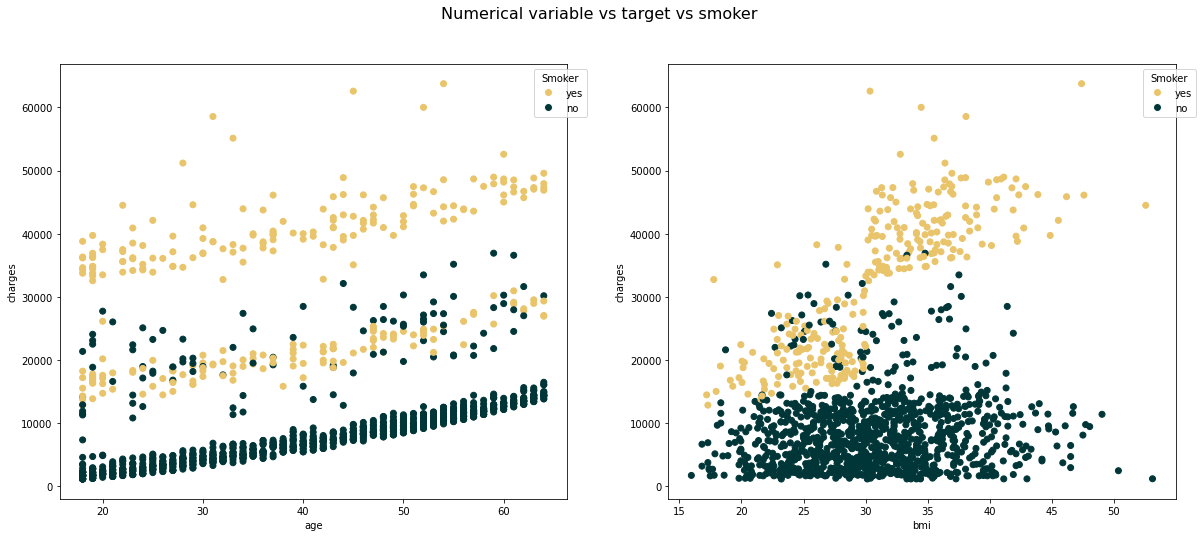

In [16]:
var = ['age','bmi']
color = {'yes':'#e9c46a','no':'#003638'}

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
fig.suptitle("Numerical variable vs target vs smoker", fontsize=16)
handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in color.items()]

for r in range(0,2):
    ax[r].scatter(dataset[var[r]],dataset['charges'],color=dataset['smoker'].map(color))
    ax[r].set_xlabel(var[r])
    ax[r].set_ylabel("charges")
    ax[r].legend(title='Smoker', handles=handles, bbox_to_anchor=(1.05, 1), loc='upper right')
    

plt.show()

dari hasil ploting diatas menunjukan bahwa orang yang tidak merokok baik itu muda ataupun tua, baik itu memiliki bmi yang rendah atau tinggi, kemungkinan besar memiliki biaya asuransi yang rendah begitu juga sebaliknya.

#### Correlation between features and target

In [17]:
encoded = pd.get_dummies(dataset2, drop_first=True)

<AxesSubplot:title={'center':'Correlation with Charges'}>

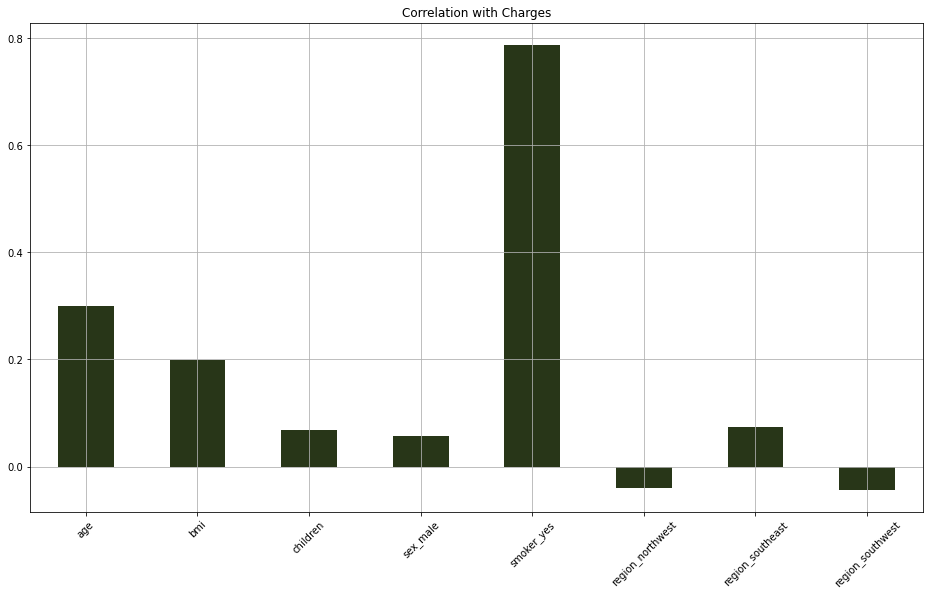

In [18]:
dataset_2 = encoded.drop(columns='charges')
dataset_2.corrwith(dataset['charges']).plot.bar(
    figsize=(16,9), title='Correlation with Charges', rot=45, grid=True, color='#283618'
)

hubungan korelasi secara liniear fitur dengan targetnya menunjukan bahwa fitur smoker memiliki korelasi positif yang sangat kuat sedangkan fitur lainya memiliki nilai korelasi yang lemah yaitu dibawah 0.3

## 3. Data pre-processing

### Split dataset to x and y

In [19]:
x = dataset.drop(columns='charges',axis=1).reset_index(drop=True)
y = dataset['charges'].reset_index(drop=True)

### Make variable target to normal distribution

Dikarenakan distribusi pada variable target memiliki kemencengan garis serta nilai kurtosis dibawah 3, untuk itu kita akan mentrasformasi variabel target agar lebih mendekati distribusi normal dengan menggunakan log function.

<AxesSubplot:>

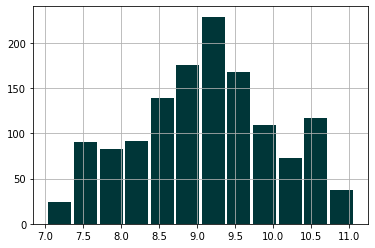

In [20]:
y_nd = y.apply(lambda x: np.log(x))
y_nd.hist(rwidth =0.9 , bins=12,color = '#003638')

In [135]:
stats.normaltest(y_nd)

NormaltestResult(statistic=52.71670509113935, pvalue=3.5703676381337117e-12)

### Features scaling

feature scaling yang digunakan adalah standard scaler atau meruabah data sehingga memiliki rata - rata 0 dan standard deviasi = 1

In [21]:
column_num = ['age','bmi']
sc = StandardScaler().fit(x[column_num])
std = pd.DataFrame(sc.transform(x[column_num]),columns=column_num)

### Encoding categorical variable

Beberapa categorical variable perlu dilakukan transformasi atau biasa kita sebut encoding. teknik yang digunakan yaitu one hot encoding atau merubah semua kemungkinan nilainya menjadi 0 atau 1

In [22]:
column_cat = ['sex','smoker','region']
encoder = OneHotEncoder(drop='first',sparse=False,handle_unknown='error').fit(x[column_cat])
x_encoded = pd.DataFrame(encoder.transform(x[column_cat]),columns=encoder.get_feature_names(column_cat))

### Features selection

Tidak semua fitur mempunyai pengaruh yang kuat untuk memprediksi biaya asuransi yang harus dibayar, untuk itu untuk meminimalisir kesalahan pada model kita akan memilih beberapa fitur saja yang mana fitur tersebut mempunyai pengaruh yang besar terhadap keputusan target. Salah satu teknik untuk memilih fitur yaitu Select K Best dengan menggunakan score function f_regression atau memilih k fitur yang memiliki pengaruh paling tinggi. 

In [23]:
features = pd.concat([std,x['children'].astype(int),x_encoded],axis=1)

In [24]:
selectorK = SelectKBest(score_func=f_regression,k=4).fit(features,y_nd)

In [25]:
f_score = selectorK.scores_
columns = list(features.columns)
print("")
print("")
print("  Feature        ","        F-Score    ")
print("  -------        ", "        -------    ")

for i in range(0,len(columns)):
    f1 = "%4.2f" % f_score[i]
    print(" ", columns[i].ljust(22), f1.rjust(9))

cols = selectorK.get_support(indices=True)
selectedCols = features.columns[cols].to_list()
non_selectedCols = features.drop(columns=selectedCols).columns
print("kolom yang akan dihilangkan = ",non_selectedCols)



  Feature                 F-Score    
  -------                 -------    
  age                       515.98
  bmi                        23.94
  children                   35.70
  sex_male                    0.04
  smoker_yes               1062.12
  region_northwest            0.42
  region_southeast            0.33
  region_southwest            2.32
kolom yang akan dihilangkan =  Index(['sex_male', 'region_northwest', 'region_southeast', 'region_southwest'], dtype='object')


In [26]:
features_selected = features[selectedCols]

Setelah melihat hasi dari f-test, maka kita akan memilih 4 fitur yang paling berpengaruh pada keputusan target, 4 fitur tersebut yaitu age, bmi, children, dan smoker.

### Split dataset to train and test

In [27]:
x_train, x_test, y_train, y_test = train_test_split(features_selected,y_nd,test_size=0.2,random_state=2021)

## 4. Build predictive model

Pada project ini kita akan menggunakan 5 model untuk memprediksi biaya asuransi, dan dari 5 model tersebut akan dipilih 1 model terbaik. 5 model yang akan dibandingkan yaitu:
- Linear Regression
- Random Forest Regression
- XGBoost Regression
- Support vector machine Regression
- K-nearest neighbor regression

### Linear Regression

In [28]:
lr = LinearRegression()
lr.fit(x_train,y_train)

LinearRegression()

In [29]:
lr_test_score = lr.score(x_test,y_test)
print("test score :",lr_test_score)

test score : 0.7326056511760909


In [49]:
lr_ypred = lr.predict(x_test)
lr_rmse = round(np.sqrt(mean_squared_error(y_test,lr_ypred)),5)
print("Root mean square error :",lr_rmse)

Root mean square error : 0.47199


### Random forest regression

In [35]:
rf = RandomForestRegressor(random_state=2021)
rf.fit(x_train,y_train)

RandomForestRegressor(random_state=2021)

In [36]:
rf_test_score = rf.score(x_test,y_test)
print("test score :",rf_test_score)

test score : 0.752640754793846


In [37]:
rf_ypred = rf.predict(x_test)
rf_rmse = round(np.sqrt(mean_squared_error(y_test,rf_ypred)),5)
print("Root mean square error :",rf_rmse)

Root mean square error : 0.45397


### XGBRegression

In [38]:
xgb = XGBRFRegressor(random_state=2021)
xgb.fit(x_train,y_train)

XGBRFRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bytree=1, gamma=0, gpu_id=-1, importance_type='gain',
               interaction_constraints='', max_delta_step=0, max_depth=6,
               min_child_weight=1, missing=nan, monotone_constraints='()',
               n_estimators=100, n_jobs=4, num_parallel_tree=100,
               objective='reg:squarederror', random_state=2021, reg_alpha=0,
               scale_pos_weight=1, tree_method='exact', validate_parameters=1,
               verbosity=None)

In [39]:
xgb_test_score = xgb.score(x_test,y_test)
print("test score :",xgb_test_score)

test score : 0.7895543005244681


In [40]:
xgb_ypred = xgb.predict(x_test)
xgb_rmse = round(np.sqrt(mean_squared_error(y_test,xgb_ypred)),4)
print("Root mean square error :",xgb_rmse)

Root mean square error : 0.4187


### Support vector machine regression

In [41]:
svm = SVR()
svm.fit(x_train,y_train)

SVR()

In [42]:
svm_test_score = svm.score(x_test,y_test)
print("test score :",svm_test_score)

test score : 0.7652347047851925


In [43]:
svm_ypred = svm.predict(x_test)
svm_rmse = round(np.sqrt(mean_squared_error(y_test,svm_ypred)),4)
print("Root mean square error:",svm_rmse)

Root mean square error: 0.4423


### K-nearest neighbor regression

In [44]:
knn = KNeighborsRegressor()
knn.fit(x_train,y_train)

KNeighborsRegressor()

In [45]:
knn_test_score = knn.score(x_test,y_test)
print("test score :",knn_test_score)

test score : 0.7551952351357699


In [47]:
knn_ypred = knn.predict(x_test)
knn_rmse = round(np.sqrt(mean_squared_error(y_test,knn_ypred)),4)
print("Root mean square error :",knn_rmse)

Root mean square error : 0.4516


### Result comparation

In [50]:
df_dict = {'Model':['Liniear Regression','Random Forest','Support Vector Machine','XGBoost','K-Nearest neighbor'],
          'Score Test Set':[lr_test_score,rf_test_score,svm_test_score,xgb_test_score,knn_test_score],
          'Root mean square error':[lr_rmse,rf_rmse,svm_rmse,xgb_rmse,knn_rmse]}
df_result = pd.DataFrame(df_dict)
df_result

,Model,Score Test Set,Root mean square error
0,Liniear Regression,0.732606,0.47199
1,Random Forest,0.752641,0.45397
2,Support Vector Machine,0.765235,0.44230
3,XGBoost,0.789554,0.41870
4,K-Nearest neighbor,0.755195,0.45160


Berdasarkan hasil dari evaluasi setiap model diatas, model yang memiliki score dan error terbaik yaitu pada model XGBoost Regression. Untuk meningkatkan performa dari model, kita akan mencoba untuk melakukan hyperparameter tuning dari model XGBoost Regression tersebut

## 5. Final model

### XGBoost parameters tunning

In [77]:
xgb_tune = XGBRFRegressor(random_state=2021)
xgb_param = {'colsample_bynode':[0.8,0.9,1],
            'learning_rate':[0.75,1,1.25],
            'colsample_bytree':[0.9,0.95, 1],
            'gamma':[0.5,0.55,0.575,0.6],
            'max_depth': [4,5,6],
            'n_estimators':[100,200,300]}

#### Cross Validation

In [78]:
cv = KFold(n_splits=10,random_state=2021,shuffle=True)

#### Grid Search CV

In [79]:
xgb_grid = GridSearchCV(xgb_tune,
                        param_grid=xgb_param,
                        scoring='neg_root_mean_squared_error',
                        cv=cv,
                        n_jobs=-1)

In [80]:
xgb_grid_fit = xgb_grid.fit(x_train,y_train)

In [81]:
xgb_grid_fit.best_score_

-0.3668608731552937

In [82]:
xgb_grid_fit.best_params_

{'colsample_bynode': 0.8,
 'colsample_bytree': 1,
 'gamma': 0.5,
 'learning_rate': 1,
 'max_depth': 5,
 'n_estimators': 200}

#### Final Evaluation

In [51]:
xgb_final = XGBRFRegressor(n_estimators=200,learning_rate=1,colsample_bytree=1,
                          gamma=0.5, max_depth=5,colsample_bynode=0.8)
xgb_final.fit(x_train,y_train)

XGBRFRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bytree=1, gamma=0.5, gpu_id=-1, importance_type='gain',
               interaction_constraints='', max_delta_step=0, max_depth=5,
               min_child_weight=1, missing=nan, monotone_constraints='()',
               n_estimators=200, n_jobs=4, num_parallel_tree=200,
               objective='reg:squarederror', random_state=0, reg_alpha=0,
               scale_pos_weight=1, tree_method='exact', validate_parameters=1,
               verbosity=None)

In [52]:
xgb_final_train_score = xgb_final.score(x_train,y_train)
xgb_final_test_score = xgb_final.score(x_test,y_test)
print("train score :",xgb_final_train_score)
print("test score :",xgb_final_test_score)

train score : 0.8599521438103501
test score : 0.7927804827836588


In [53]:
xgb_final_ypred = xgb_final.predict(x_test)
xgb_final_rmse = round(np.sqrt(mean_squared_error(y_test,xgb_final_ypred)),4)
print("Root mean square error :",xgb_final_rmse)

Root mean square error : 0.4155


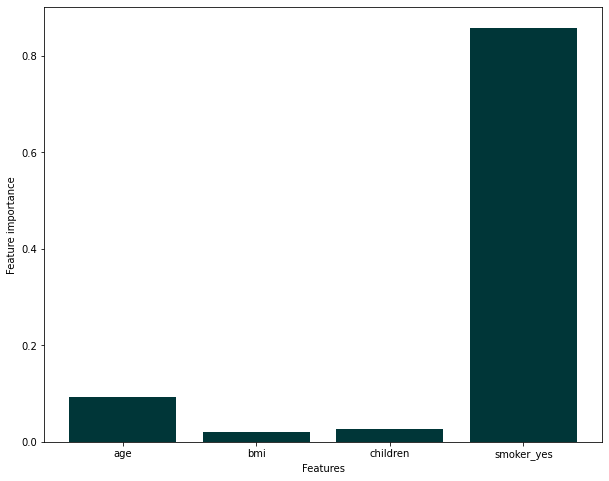

In [54]:
plt.figure(figsize=(10,8))
plt.bar(selectedCols,xgb_final.feature_importances_,color='#003638')
plt.xlabel("Features")
plt.ylabel("Feature importance")
plt.show()

In [56]:
df_final = pd.DataFrame([['XGBoost Final',xgb_final_test_score,xgb_final_rmse]],
                       columns=['Model','Score Test Set','Root mean square error'])
result = pd.concat([df_result,df_final],axis=0).reset_index(drop=True)
result

,Model,Score Test Set,Root mean square error
0,Liniear Regression,0.732606,0.47199
1,Random Forest,0.752641,0.45397
2,Support Vector Machine,0.765235,0.44230
3,XGBoost,0.789554,0.41870
4,K-Nearest neighbor,0.755195,0.45160
5,XGBoost Final,0.792780,0.41550


Dari hasil hyperparamter tuning tersebut menunjukan bahwa setelah dilakukannya hyperparameter tuning, model XGBoost mengalami peningkatan performa walaupun tidak banyak. hasil evaluasi final menunjukan model XGBoost memiliki score test set yaitu 79.28 % dan nilai RMSE 0.4155

#### Save XGBoost model

In [57]:
joblib.dump(xgb_final,'xgboost_model.pkl')

['xgboost_model.pkl']

#### Save XGBoost parameters

In [58]:
joblib.dump(xgb_final.get_params(),'xgboost_params.pkl')

['xgboost_params.pkl']

#### Save features

In [59]:
features_dict = {'features predictor':selectedCols,
                'features encoder':['sex','smoker','region'],
                'features scaler':['age','bmi']}
joblib.dump(features_dict,'features.pkl')

['features.pkl']

#### Save one hot encoding

In [60]:
joblib.dump(encoder,'encoder.pkl')

['encoder.pkl']

#### Save Standard scaler

In [61]:
joblib.dump(sc,'standardscaler.pkl')

['standardscaler.pkl']

## 6. Single prediction of observation

Setelah mendapatkan model untuk memprediksi biaya asuransi, kita akan menggunakan model tersebut untuk memprediksi biaya asuransi dengan menggunakan single data. Adapun beberapa tahap yang harus dilakukan untuk dapat hasil prediksi, yaitu:
1. Load model, features, encoder, and standard scaler
2. Input single data
3. Feature engineering
    - encoding categorical features
    - Standardization numerical data
    - Features selection
4. charges prediction

### Load model, features, encoder, and standard scaler

In [62]:
model = joblib.load('xgboost_model.pkl')
features = joblib.load('features.pkl')
encoder = joblib.load('encoder.pkl')
sc = joblib.load('standardscaler.pkl')

### Example 1

##### Data

In [113]:
data = {'age':19,'sex':'male','bmi':20.4,'children':0,'smoker':'no','region':'southeast'}
df_data = pd.Series(data)
df_data

age                19
sex              male
bmi              20.4
children            0
smoker             no
region      southeast
dtype: object

#### Feature engineering

##### 1. encoding categorical features

In [114]:
num_column = features['features scaler']
num_features = np.array(df_data[num_column]).reshape(1,-1)

In [115]:
std = pd.Series(sc.transform(num_features).reshape(2,),index=num_column)

##### 2. Standardization numerical data

In [116]:
cat_column = features['features encoder']
cat_features = np.array(df_data[cat_column]).reshape(1,-1)

In [117]:
encoded = pd.Series(encoder.transform(cat_features).reshape(5,),index=encoder.get_feature_names(cat_column))

##### 3. Features selection

In [118]:
data_prepro= pd.concat([std,pd.Series(df_data.children,index=['children']),encoded])
features_selected = data_prepro[features['features predictor']]

#### Charges prediction

In [119]:
charges = model.predict(np.array(features_selected).reshape(1,-1))
print(df_data)
print("")
print("Charges :",np.exp(charges))

age                19
sex              male
bmi              20.4
children            0
smoker             no
region      southeast
dtype: object

Charges : [1894.8872]


### Example 2

#### Data

In [120]:
data = {'age':50,'sex':'male','bmi':23.4,'children':1,'smoker':'no','region':'southwest'}
df_data = pd.Series(data)
df_data

age                50
sex              male
bmi              23.4
children            1
smoker             no
region      southwest
dtype: object

#### Feature engineering

##### 1. encoding categorical features

In [121]:
num_column = features['features scaler']
num_features = np.array(df_data[num_column]).reshape(1,-1)

In [122]:
std = pd.Series(sc.transform(num_features).reshape(2,),index=num_column)

##### 2. Standardization numerical data

In [123]:
cat_column = features['features encoder']
cat_features = np.array(df_data[cat_column]).reshape(1,-1)

In [124]:
encoded = pd.Series(encoder.transform(cat_features).reshape(5,),index=encoder.get_feature_names(cat_column))

##### 3. Features selection

In [125]:
data_prepro= pd.concat([std,pd.Series(df_data.children,index=['children']),encoded])
features_selected = data_prepro[features['features predictor']]

#### Charges prediction

In [126]:
charges = model.predict(np.array(features_selected).reshape(1,-1))
print(df_data)
print("")
print("Charges :",np.exp(charges))

age                50
sex              male
bmi              23.4
children            1
smoker             no
region      southwest
dtype: object

Charges : [10511.973]


## 7. Conclution

kesimpulan yang didapatkan dari project ini, yaitu:
- range biaya asuransi berdasarkan data sebelumnya yaitu 1121.8739 - 63770.428010
- kondisi orang yang merokok dan tidak sangat menentukan biaya asuransi, yang mana orang yang merokok cenderung mendapatkan biaya asuransi yang tinggi dibandingkan dengan orang yang tidak merokok
- hasil performa model untuk memprediksi biaya asuransi terbilang baik, dengan model terbaiknya yaitu XGBoost yang memiliki akurasi sebesar 79.278 % dan nilai errornya 0.41550
- fitur yang digunakan untuk prediksi biaya asuransi yaitu, umur, indek massa tubuh, jumlah anak yang ditanggung asuransi, dan orang merokok atau tidak.

Adapun file terlampir dari hasil project ini:

- xgboost_model.pkl : file model XGBoost yang sudah dilatih dan siap digunakan
- xgboost_params.pkl : file list parameter XGBoost yang digunakan untuk melatih model
- standardscaler.pkl : file standard scaler untuk normalisasi variabel numerik
- encoder.pkl : file one hot encoder untuk encoding variabel kategori
- features : list feature yang digunakan untuk melakukan prediksi, encoding, dan standarisasi

<h1 align='center'> End <h1>